In [2]:
import numpy as np
import pandas as pd
import os

from matplotlib import pyplot as plt

from scipy import stats

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import pickle

from tqdm import tqdm

### Предобработка и анализ данных

In [3]:
data = pd.read_csv("./data/new_scooters_trips_info.csv", index_col=0)
data

,average_speed,peak_speed,average_acceleration,peak_acceleration,rapid_overclock,hard_braking
0,6.443223,7.388889,-0.011087,0.977465,0.0,0.0
1,5.237365,7.500000,-0.007952,2.199546,0.0,0.0
2,4.968280,7.083333,-0.030921,1.382306,0.0,0.0
3,6.049740,7.500000,-0.029479,1.229105,0.0,3.0
4,6.428615,7.555556,-0.062866,0.950728,0.0,0.0
...,...,...,...,...,...,...
22498,3.907132,6.750000,0.003167,1.248171,0.0,0.0
22499,4.830391,7.611111,-0.052442,2.365561,0.0,1.0
22500,5.389947,7.250000,-0.014757,0.748727,0.0,0.0
22501,4.175000,6.722222,-0.012502,0.781178,0.0,0.0


In [4]:
for col in data.columns:
    data = data.loc[np.abs(stats.zscore(data[col])) < 3]

print(f"Count of road trips (after outlires dropping): {len(data)}")

Count of road trips (after outlires dropping): 20097


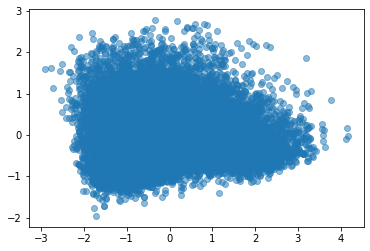

In [11]:
pca = PCA(n_components=2)
# pca = pickle.load(open("pca_model.pkl", "rb"))
pca_data = pca.fit_transform(data)
# pca_data = pca.transform(data)
plt.scatter(pca_data[:, 0], pca_data[:, 1], alpha=0.5)

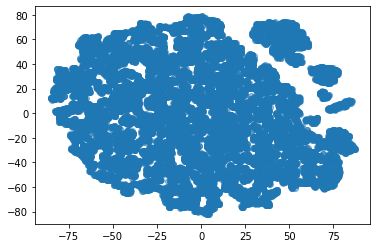

In [20]:
tsne = TSNE(n_components=2)
tsne_data = tsne.fit_transform(data)
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], alpha=0.5)
plt.show()

In [13]:
def get_distribution(df, column_name):
    min_v = int(df[column_name].min())
    max_v = int(df[column_name].max())
    r = range(min_v, max_v+1, 1)
    hist = df.hist(column_name, bins=r, figsize=(15, 5))
    return hist

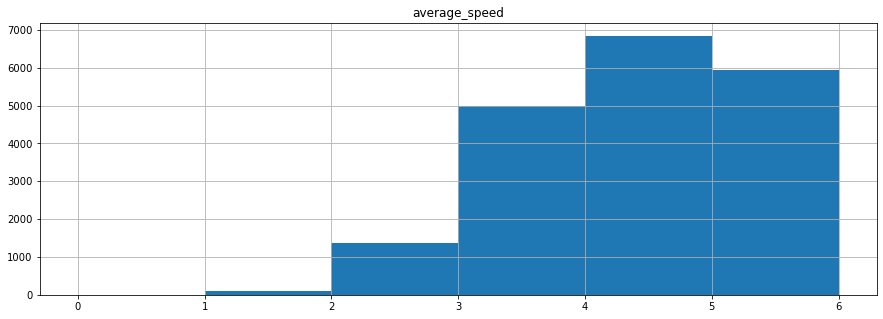

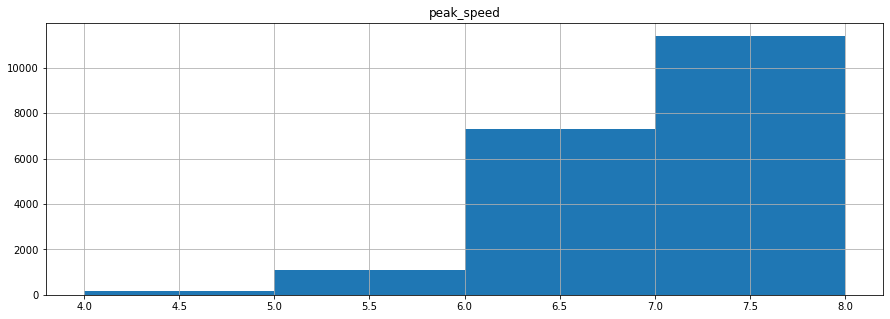

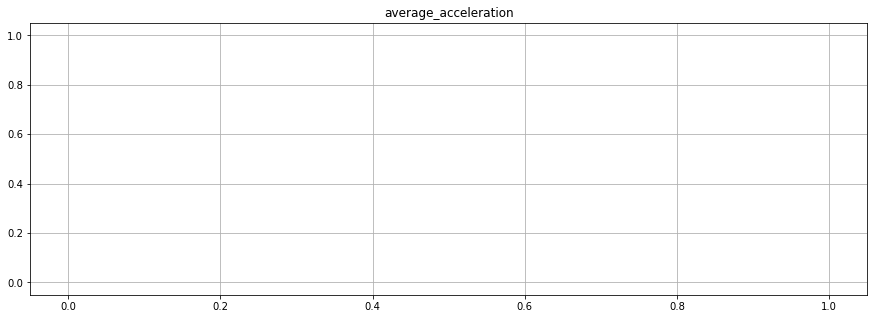

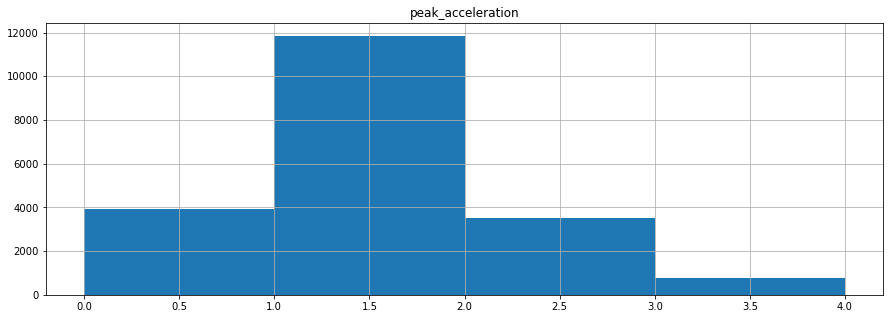

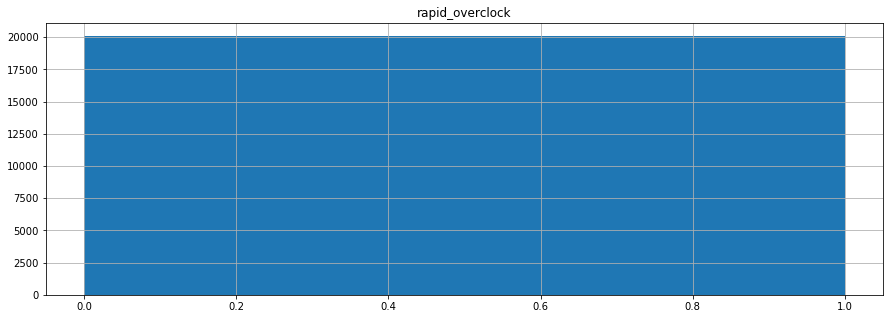

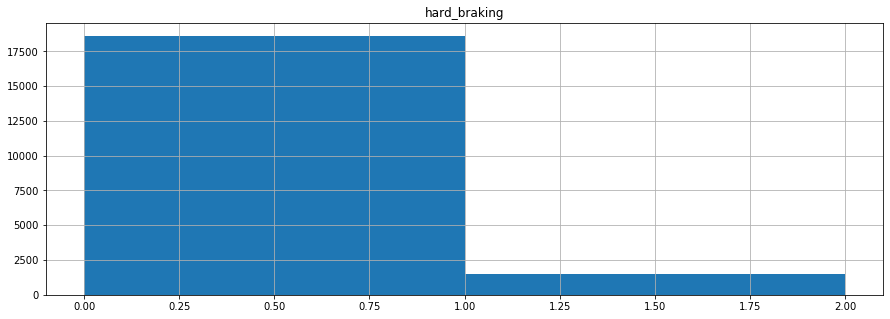

In [14]:
N = len(data.columns)
for i in range(N):
    col = data.columns[i]
    # print(col)
    get_distribution(data, col)

### Сетка параметров кластеризации

In [15]:
scale_models = [MinMaxScaler(), StandardScaler(), RobustScaler()]
cluster_models = [KMeans(), AgglomerativeClustering(), DBSCAN()]

### Эксперименты

In [16]:
def visualisation(tsne_data, c_predicted, n_clusters):
    d = {0: "Корректное поведение", 1:"Опасное поведение", 2:"Потенциально опасное\nповедение"}
    for i in range(n_clusters):
        plt.scatter(tsne_data[c_predicted == i, 0], tsne_data[c_predicted == i, 1], alpha=0.5, label=i) #d[i]
        plt.legend(loc=0)
    plt.show()

In [17]:
def show_kmeans(X, data, tsne_data):
    
    # Метод локтя
    print("Elbow method")
    sse = []
    k_rng = range(1,13)
    for k in k_rng:
        km = KMeans(n_clusters=k, init="random", random_state=42)
        km.fit(X)
        sse.append(km.inertia_)

    plt.xlabel("K")
    plt.ylabel("Sum of squared distances")
    plt.plot(k_rng, sse, marker="o")
    plt.show()
    
    # Отображение информации о кластерах
    for i in range(2, 6):
        n_clusters = i
        km = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
        c_predicted = km.fit_predict(X)
        
        # Силуэт
        estimation_score = silhouette_score(X, c_predicted)
        print(f"{n_clusters} clusters silhouette_score: {estimation_score}")
        
        # Средние значения
        data["cluster"] = c_predicted
        for c in range(n_clusters):
            cluster_members = data[data['cluster'] == c]
            print('Cluster {} size: {}'.format(c, len(cluster_members)))
        desc = data.groupby(["cluster"])
        desc = pd.DataFrame(desc.mean())
        display(desc)
        data.drop(["cluster"], axis=1, inplace=True)
        
        # Визуализация
        visualisation(tsne_data, c_predicted, n_clusters)

MinMaxScaler(copy=True, feature_range=(0, 1))
Elbow method


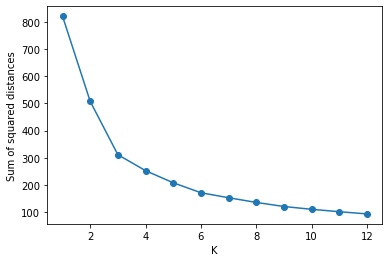

2 clusters silhouette_score: 0.3638409496352273
Cluster 0 size: 8103
Cluster 1 size: 11994


,average_speed,peak_speed,average_acceleration,peak_acceleration,rapid_overclock,hard_braking
cluster,,,,,,
0,3.510538,6.596120,-0.028077,1.299980,0.002715,0.031593
1,5.142361,7.224256,-0.023593,1.729727,0.017342,0.133317


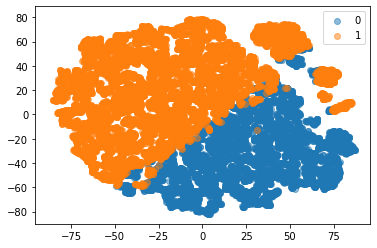

3 clusters silhouette_score: 0.4066387739697932
Cluster 0 size: 6872
Cluster 1 size: 8575
Cluster 2 size: 4650


,average_speed,peak_speed,average_acceleration,peak_acceleration,rapid_overclock,hard_braking
cluster,,,,,,
0,3.463876,6.529670,-0.028345,1.151874,0.000000,0.021391
1,5.235070,7.183330,-0.024014,1.375358,0.000000,0.080000
2,4.608364,7.231643,-0.023607,2.488325,0.049462,0.219785


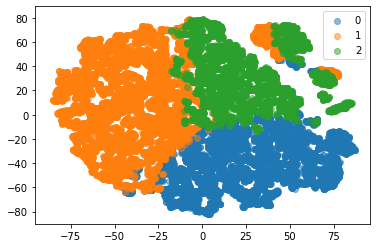

4 clusters silhouette_score: 0.34219070465397605
Cluster 0 size: 6464
Cluster 1 size: 6056
Cluster 2 size: 3916
Cluster 3 size: 3661


,average_speed,peak_speed,average_acceleration,peak_acceleration,rapid_overclock,hard_braking
cluster,,,,,,
0,5.461481,7.235462,-0.022413,1.398221,0.000000,0.091275
1,4.192909,6.964195,-0.028497,1.368380,0.000000,0.048382
2,4.643778,7.244127,-0.022996,2.600484,0.058733,0.235700
3,3.071035,6.223133,-0.028129,1.030204,0.000000,0.013384


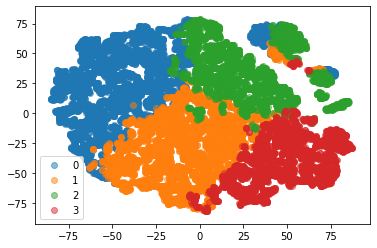

5 clusters silhouette_score: 0.3499931623575302
Cluster 0 size: 3552
Cluster 1 size: 5824
Cluster 2 size: 5444
Cluster 3 size: 2165
Cluster 4 size: 3112


,average_speed,peak_speed,average_acceleration,peak_acceleration,rapid_overclock,hard_braking
cluster,,,,,,
0,3.089994,6.210773,-0.028180,0.985752,0.000000,0.011543
1,4.246678,6.969489,-0.028394,1.336217,0.000000,0.044815
2,5.486822,7.216630,-0.022335,1.307960,0.000000,0.069067
3,3.834478,7.035617,-0.025969,2.483292,0.058661,0.157506
4,5.219523,7.366859,-0.021596,2.409929,0.033098,0.268638


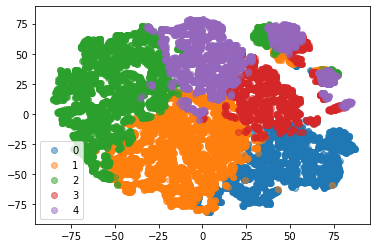

StandardScaler(copy=True, with_mean=True, with_std=True)
Elbow method


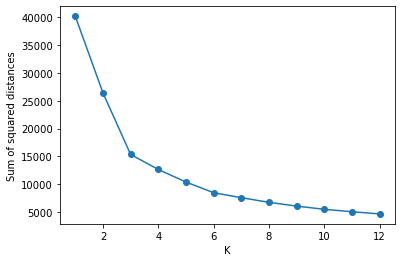

2 clusters silhouette_score: 0.3418554638863041
Cluster 0 size: 8374
Cluster 1 size: 11723


,average_speed,peak_speed,average_acceleration,peak_acceleration,rapid_overclock,hard_braking
cluster,,,,,,
0,3.528338,6.616140,-0.028053,1.347441,0.005016,0.037616
1,5.167369,7.224476,-0.023507,1.705759,0.016037,0.131366


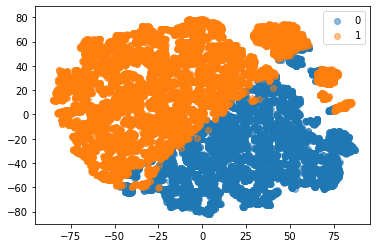

3 clusters silhouette_score: 0.40454935083263904
Cluster 0 size: 6769
Cluster 1 size: 8561
Cluster 2 size: 4767


,average_speed,peak_speed,average_acceleration,peak_acceleration,rapid_overclock,hard_braking
cluster,,,,,,
0,3.470904,6.527761,-0.028378,1.140218,0.000000,0.020830
1,5.236562,7.182251,-0.024005,1.372597,0.000000,0.079897
2,4.572816,7.220981,-0.023680,2.477689,0.048248,0.216069


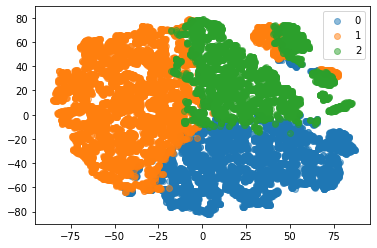

4 clusters silhouette_score: 0.3489362986988083
Cluster 0 size: 5836
Cluster 1 size: 6274
Cluster 2 size: 2713
Cluster 3 size: 5274


,average_speed,peak_speed,average_acceleration,peak_acceleration,rapid_overclock,hard_braking
cluster,,,,,,
0,5.324126,7.145771,-0.023543,1.205540,0.000000,0.050548
1,3.418303,6.491548,-0.028294,1.111369,0.000000,0.018808
2,4.354984,7.181134,-0.023323,2.736067,0.084777,0.231478
3,4.890076,7.239851,-0.025085,1.867440,0.000000,0.154342


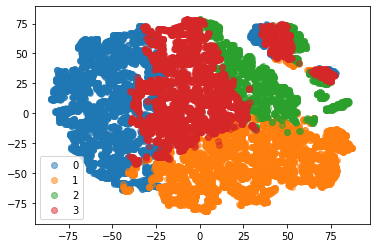

5 clusters silhouette_score: 0.3359862107358293
Cluster 0 size: 5078
Cluster 1 size: 2578
Cluster 2 size: 5574
Cluster 3 size: 3199
Cluster 4 size: 3668


,average_speed,peak_speed,average_acceleration,peak_acceleration,rapid_overclock,hard_braking
cluster,,,,,,
0,5.427412,7.170354,-0.022856,1.214297,0.000000,0.051004
1,4.251033,7.152993,-0.023945,2.714598,0.089216,0.222653
2,4.075938,6.940617,-0.028818,1.347382,0.000000,0.040545
3,3.044120,6.143778,-0.028032,0.959492,0.000000,0.008753
4,5.219844,7.334696,-0.022461,2.054505,0.000000,0.209378


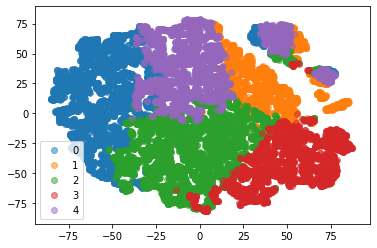

RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True)
Elbow method


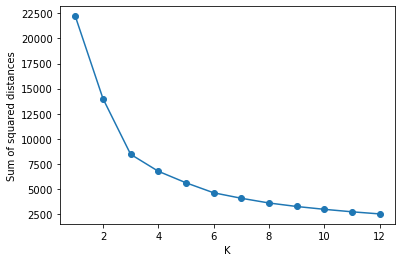

2 clusters silhouette_score: 0.3619666766174081
Cluster 0 size: 13714
Cluster 1 size: 6383


,average_speed,peak_speed,average_acceleration,peak_acceleration,rapid_overclock,hard_braking
cluster,,,,,,
0,4.525182,6.885778,-0.025940,1.212178,0.000000,0.046959
1,4.396840,7.154086,-0.024244,2.296143,0.036033,0.189723


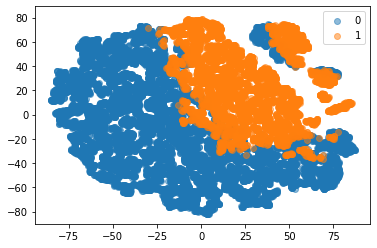

3 clusters silhouette_score: 0.39874044168766204
Cluster 0 size: 8526
Cluster 1 size: 6681
Cluster 2 size: 4890


,average_speed,peak_speed,average_acceleration,peak_acceleration,rapid_overclock,hard_braking
cluster,,,,,,
0,5.234040,7.178109,-0.023971,1.363312,0.000000,0.078583
1,3.477134,6.529482,-0.028390,1.136495,0.000000,0.020805
2,4.553623,7.213099,-0.023811,2.466986,0.047035,0.213906


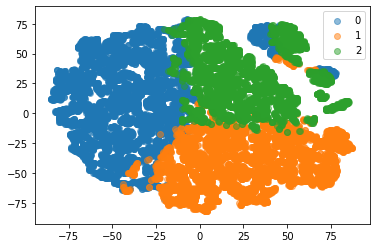

4 clusters silhouette_score: 0.35514580141893515
Cluster 0 size: 5379
Cluster 1 size: 5943
Cluster 2 size: 6003
Cluster 3 size: 2772


,average_speed,peak_speed,average_acceleration,peak_acceleration,rapid_overclock,hard_braking
cluster,,,,,,
0,4.857953,7.231858,-0.025096,1.865015,0.000000,0.150772
1,5.308327,7.140628,-0.023663,1.203198,0.000000,0.050311
2,3.403866,6.475924,-0.028228,1.091140,0.000000,0.017991
3,4.333203,7.173230,-0.023596,2.722745,0.082973,0.229798


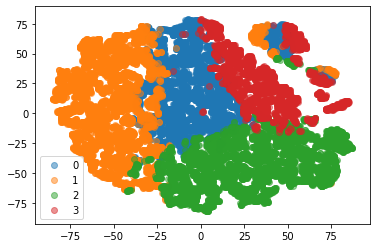

5 clusters silhouette_score: 0.34224548212660416
Cluster 0 size: 5270
Cluster 1 size: 3070
Cluster 2 size: 4501
Cluster 3 size: 5025
Cluster 4 size: 2231


,average_speed,peak_speed,average_acceleration,peak_acceleration,rapid_overclock,hard_braking
cluster,,,,,,
0,5.351430,7.144065,-0.023567,1.181173,0.000000,0.046869
1,3.540283,6.878104,-0.027765,1.718772,0.000000,0.065472
2,3.462487,6.372096,-0.028275,0.934581,0.000000,0.006887
3,4.994671,7.254334,-0.024572,1.816065,0.000000,0.150448
4,4.648047,7.260085,-0.022550,2.889464,0.103093,0.277902


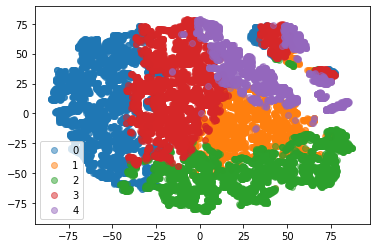

In [21]:
for scaler in scale_models:
    print(scaler)
    # X = data.values.tolist()
    X = pca_data
    X = scaler.fit_transform(X)
    show_kmeans(X, data, tsne_data)
    print("="*127)

Наилучший результат показала модель, использующая для масштабирования данных **MinMaxScaler** и разделяющая их на **3 кластера**  
_Shillluette = 0.406_

In [26]:
def visualisation(tsne_data, c_predicted, n_clusters):
    d = {0: "Корректное поведение", 1:"Потенциально опасное\nповедение", 2:"Опасное поведение"}
    for i in range(n_clusters):
        plt.scatter(tsne_data[c_predicted == i, 0], tsne_data[c_predicted == i, 1], alpha=0.5, label=d[i])
        plt.legend(loc=0)
    plt.show()

3 clusters silhouette_score: 0.4066387739697932
Cluster 0 size: 6872
Cluster 1 size: 8575
Cluster 2 size: 4650


,average_speed,peak_speed,average_acceleration,peak_acceleration,rapid_overclock,hard_braking
cluster,,,,,,
0,3.463876,6.529670,-0.028345,1.151874,0.000000,0.021391
1,5.235070,7.183330,-0.024014,1.375358,0.000000,0.080000
2,4.608364,7.231643,-0.023607,2.488325,0.049462,0.219785


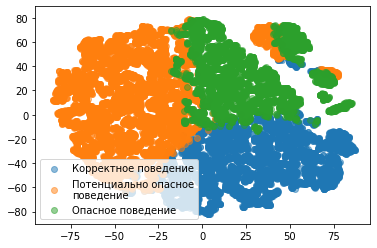

In [27]:
X = pca_data
scaler = scale_models[0].fit(X)
X = scaler.transform(X)

n_clusters = 3
km = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
c_predicted = km.fit_predict(X)
        
# Силуэт
estimation_score = silhouette_score(X, c_predicted)
print(f"{n_clusters} clusters silhouette_score: {estimation_score}")
        
# Средние значения
data["cluster"] = c_predicted
for c in range(n_clusters):
    cluster_members = data[data['cluster'] == c]
    print('Cluster {} size: {}'.format(c, len(cluster_members)))
desc = data.groupby(["cluster"])
desc = pd.DataFrame(desc.mean())
display(desc)

visualisation(tsne_data, c_predicted, n_clusters)

### Сохранение модели

In [24]:
pickle.dump(km, open("k-means_model_new.pkl", "wb"))
pickle.dump(pca, open("pca_model_new.pkl", "wb"))

In [25]:
pickle.dump(scaler, open("scaler_new.pkl", "wb"))